# Veille Technique : évaluation des Embeddings E5-large-v2 pour la classification de produits e-commerce

Cette mission évalue E5-large-v2 (2023) face à BERT (2018) dans leurs conditions d'usage optimales : BERT avec preprocessing, E5-large-v2 sur texte brut. L'objectif est de quantifier l'apport réel des embeddings récents pour la classification de produits e-commerce.

L'ARI (Adjusted Rand Index) est choisi comme métrique principale car il mesure comment les embeddings regroupent naturellement les produits similaires, ce qui révéle la qualité des représentations sémantiques

# Packages pour E5-large-v2

Installation des packages pour comparer BERT et E5-large-v2.
Sentence-transformers donne accès aux modèles récents, transformers/torch
permettent d'utiliser BERT, et scikit-learn fournit les outils d'évaluation.

In [ ]:
!pip install sentence-transformers --upgrade --quiet
!pip install transformers torch --quiet
!pip install scikit-learn pandas numpy matplotlib seaborn --quiet

# Imports

Importation des outils pour l'analyse comparative : pandas et numpy
pour les données, scikit-learn pour le clustering et les métriques, matplotlib
pour la visualisation, et les librairies spécialisées pour BERT et E5-large-v2.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import ast
import string
import re
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.metrics import (
    adjusted_rand_score,
    confusion_matrix
)
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import linear_sum_assignment

# Modèles
from sentence_transformers import SentenceTransformer
from transformers import BertModel, BertTokenizer
import torch

# Configuration graphiques
plt.style.use('default')
sns.set_palette("husl")

# Chargement des données

Chargement du dataset Flipkart contenant 1050 produits répartis équitablement
sur 7 catégories. Cette distribution parfaite élimine les biais de classe et
permet une évaluation des 2 techniques d'embeddings.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

project_path = '/content/drive/MyDrive/Colab Notebooks/Projet 6'
df = pd.read_csv(f'{project_path}/flipkart_com-ecommerce_sample_1050.csv')

print(f"Dataset chargé: {df.shape}")
print(f"Colonnes: {list(df.columns)}")

# Extraction catégories principales
def extract_main_category(category_tree):
    try:
        categories = ast.literal_eval(category_tree)
        return categories[0].split(">>")[0].strip()
    except:
        return "Unknown"

df['main_category'] = df['product_category_tree'].apply(extract_main_category)
print(f"Distribution: {df['main_category'].value_counts().to_dict()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset chargé: (1050, 15)
Colonnes: ['uniq_id', 'crawl_timestamp', 'product_url', 'product_name', 'product_category_tree', 'pid', 'retail_price', 'discounted_price', 'image', 'is_FK_Advantage_product', 'description', 'product_rating', 'overall_rating', 'brand', 'product_specifications']
Distribution: {'Home Furnishing': 150, 'Baby Care': 150, 'Watches': 150, 'Home Decor & Festive Needs': 150, 'Kitchen & Dining': 150, 'Beauty and Personal Care': 150, 'Computers': 150}


Le dataset confirme sa structure idéale avec 150 produits par catégorie,
couvrant des univers divers de Baby Care à Computers. Cette diversité sémantique constitue une base de test solide pour les embeddings.

# Test avec BERT

## Préprocessing

Nettoyage optimisé pour BERT avec suppression de 49 mots e-commerce non-discriminants et normalisation standard. Ce preprocessing améliore les performances de BERT qui fonctionne mieux sur des textes optimisés.


In [ ]:
# Mots e-commerce à supprimer
ecommerce_words = [
    'buy', 'free', 'delivery', 'shipping', 'cash', 'replacement',
    'guarantee', 'sales', 'prices', 'price', 'warranty', 'discounts',
    'only', 'genuine', 'best', 'perfect', 'great', 'ideal', 'quality',
    'online', 'day', 'package', 'box', 'features', 'specifications',
    'material', 'type', 'general', 'details', 'model', 'number',
    'product', 'products', 'brand', 'color', 'size', 'dimensions',
    'height', 'width', 'pattern', 'made', 'pack', 'set', 'combo',
    'can', 'will', 'gift', 'flipkartcom', 'fabric'
]

def clean_ecommerce_words(text, ecommerce_words):
    if not isinstance(text, str):
        return ""
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in ecommerce_words]
    return " ".join(filtered_words)

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if len(word) > 2])
    return text

# Application preprocessing BERT
df['description_cleaned_ecommerce'] = df['description'].apply(
    lambda x: clean_ecommerce_words(x, ecommerce_words)
)
df['description_cleaned'] = df['description_cleaned_ecommerce'].apply(clean_text)

texts_bert = df['description_cleaned'].tolist()
categories = df['main_category'].tolist()

print(f"Textes preprocessés pour BERT: {len(texts_bert)}")
print(f"Longueur moyenne: {np.mean([len(text.split()) for text in texts_bert]):.1f} tokens")

Textes preprocessés pour BERT: 1050
Longueur moyenne: 50.7 tokens


Le preprocessing réduit les descriptions à 50.7 tokens en moyenne, concentrant
l'information sur les caractéristiques essentielles des produits.

## Extraction des embeddings

Extraction des embeddings BERT avec mean pooling sur les textes preprocessés. Configuration standard avec tokenisation à 256 tokens maximum et traitement par batches de 16 pour optimiser la performance.

In [ ]:
print("Chargement BERT-base-uncased...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

def get_bert_embeddings(texts, batch_size=16, max_length=256):
    embeddings = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            batch_texts = [str(text) for text in batch_texts]

            encoded = tokenizer(
                batch_texts,
                padding='max_length',
                truncation=True,
                max_length=max_length,
                return_tensors='pt'
            )

            outputs = bert_model(input_ids=encoded['input_ids'],
                               attention_mask=encoded['attention_mask'])

            # Mean pooling
            last_hidden = outputs.last_hidden_state
            mask = encoded['attention_mask'].unsqueeze(-1).expand(last_hidden.size()).float()
            masked_embeddings = last_hidden * mask
            summed = torch.sum(masked_embeddings, 1)
            counts = torch.clamp(mask.sum(1), min=1e-9)
            batch_embeddings = summed / counts

            embeddings.extend(batch_embeddings.numpy())

    return np.array(embeddings)

print("Extraction embeddings BERT...")
start_time = time.time()
bert_embeddings = get_bert_embeddings(texts_bert, batch_size=16, max_length=256)
bert_time = time.time() - start_time

print(f"BERT embeddings: {bert_embeddings.shape}")
print(f"Temps extraction: {bert_time/60:.1f} minutes")

Chargement BERT-base-uncased...
Extraction embeddings BERT...
BERT embeddings: (1050, 768)
Temps extraction: 14.5 minutes


\BERT génère 1050 vecteurs de 768 dimensions en 14.5 minutes. Ce temps de traitement important reflète la complexité computationnelle de BERT mais produit des représentations sémantiques de meilleure qualité pour l'évaluation.

## Clustering et métriques

Évaluation de BERT par clustering KMeans non-supervisé sur 7 clusters correspondant
aux catégories. L'algorithme hongrois réaligne optimalement les clusters avec les
vraies catégories pour calculer des métriques supervisées objectives. Cette méthode
standard permet de mesurer la capacité de BERT à séparer naturellement les différentes
classes de produits dans l'espace vectoriel.

In [ ]:
# Clustering BERT
kmeans_bert = KMeans(n_clusters=7, random_state=42, n_init=10)
clusters_bert = kmeans_bert.fit_predict(bert_embeddings)

# Encoder catégories
label_encoder = LabelEncoder()
categories_encoded = label_encoder.fit_transform(categories)

# Métriques BERT
ari_bert = adjusted_rand_score(categories, clusters_bert)

# Réalignement optimal
cm_bert = confusion_matrix(categories_encoded, clusters_bert)
row_ind, col_ind = linear_sum_assignment(-cm_bert)
mapping_bert = dict(zip(col_ind, row_ind))
clusters_bert_aligned = np.array([mapping_bert.get(label, label) for label in clusters_bert])

print(f"ARI: {ari_bert:.4f}")

ARI: 0.3133


BERT affiche des performances modérées avec un ARI de 0.31

# Test avec  E5-large-v2

## Textes bruts sans préprocessing

Préparation des données pour E5-large-v2 dans ses conditions atendues : textes bruts sans preprocessing. E5 ayant été entraîné sur des données web non-nettoyées, il performerait mieux sur le contenu original que sur des textes épurés, contrairement à BERT.

In [ ]:
texts_e5_raw = df['description'].fillna("").tolist()
categories_e5 = df['main_category'].tolist()

print(f"Textes bruts pour E5: {len(texts_e5_raw)}")
print(f"Longueur moyenne: {np.mean([len(text.split()) for text in texts_e5_raw]):.1f} tokens")

Textes bruts pour E5: 1050
Longueur moyenne: 76.2 tokens


Les textes bruts pour E5 conservent leur richesse originale avec 76.2 tokens en moyenne, soit 50% de plus que les textes preprocessés de BERT (50.7 tokens). Cette différence illustre l'avantage d'E5 qui est la capacité à exploiter l'information complète des descriptions commerciales sans perdre les nuances sémantiques dans le nettoyage préalable.

## Extraction des embedding

Chargement d'E5-large-v2 et extraction des embeddings avec le préfixe 'query:'
obligatoire pour optimiser les performances. Ce modèle récent utilise l'apprentissage
contrastif faiblement supervisé et génère des vecteurs de 1024 dimensions.
Le batch_size réduit à 8 compense la taille plus importante du modèle.

In [ ]:
e5_model = SentenceTransformer('intfloat/e5-large-v2')

# Ajout préfixe obligatoire E5
prefixed_texts = ["query: " + str(text) for text in texts_e5_raw]

print("Extraction embeddings E5-large-v2...")
start_time = time.time()
e5_embeddings = e5_model.encode(
    prefixed_texts,
    batch_size=8,
    show_progress_bar=True,
    convert_to_numpy=True
)
e5_time = time.time() - start_time

print(f"E5 embeddings: {e5_embeddings.shape}")
print(f"Temps extraction: {e5_time/60:.1f} minutes")

Extraction embeddings E5-large-v2...


Batches:   0%|          | 0/132 [00:00<?, ?it/s]

E5 embeddings: (1050, 1024)
Temps extraction: 23.0 minutes


E5-large-v2 génère 1050 vecteurs de 1024 dimensions en 23.0 minutes, soit 9 mn  de plus que BERT malgré un batch_size réduit. Cette durée supérieure s'explique par la taille accrue du modèle (large vs base) et ses 1024 dimensions contre 768 pour BERT.

## Clustering et métriques


Évaluation d'E5-large-v2 avec le même protocole que BERT pour assurer
une comparaison. Le clustering KMeans, le réalignement optimal et les
métriques sont calculés de manière identique. Cette standardisation méthodologique permet d'attribuer les différences de performance uniquement aux capacités intrinsèques des modèles d'embeddings.

In [ ]:
# Clustering E5
kmeans_e5 = KMeans(n_clusters=7, random_state=42, n_init=10)
clusters_e5 = kmeans_e5.fit_predict(e5_embeddings)

# Métriques E5
ari_e5 = adjusted_rand_score(categories_e5, clusters_e5)

# Réalignement optimal
categories_e5_encoded = label_encoder.fit_transform(categories_e5)
cm_e5 = confusion_matrix(categories_e5_encoded, clusters_e5)
row_ind, col_ind = linear_sum_assignment(-cm_e5)
mapping_e5 = dict(zip(col_ind, row_ind))
clusters_e5_aligned = np.array([mapping_e5.get(label, label) for label in clusters_e5])

print(f"ARI: {ari_e5:.4f}")

ARI: 0.3595


E5-large-v2 surpasse nettement BERT avec un ARI de 0.36 (+15%)

# Visuels t-sne


Génération des visualisations t-SNE pour comparer visuellement la qualité de séparation
des deux modèles. La réduction à 2 dimensions révèle comment chaque technique structure
l'espace sémantique et sépare les catégories de produits. Cette représentation graphique
côte à côte permet d'observer concrètement les différences de clustering et de valider
visuellement les améliorations quantitatives mesurées précédemment.

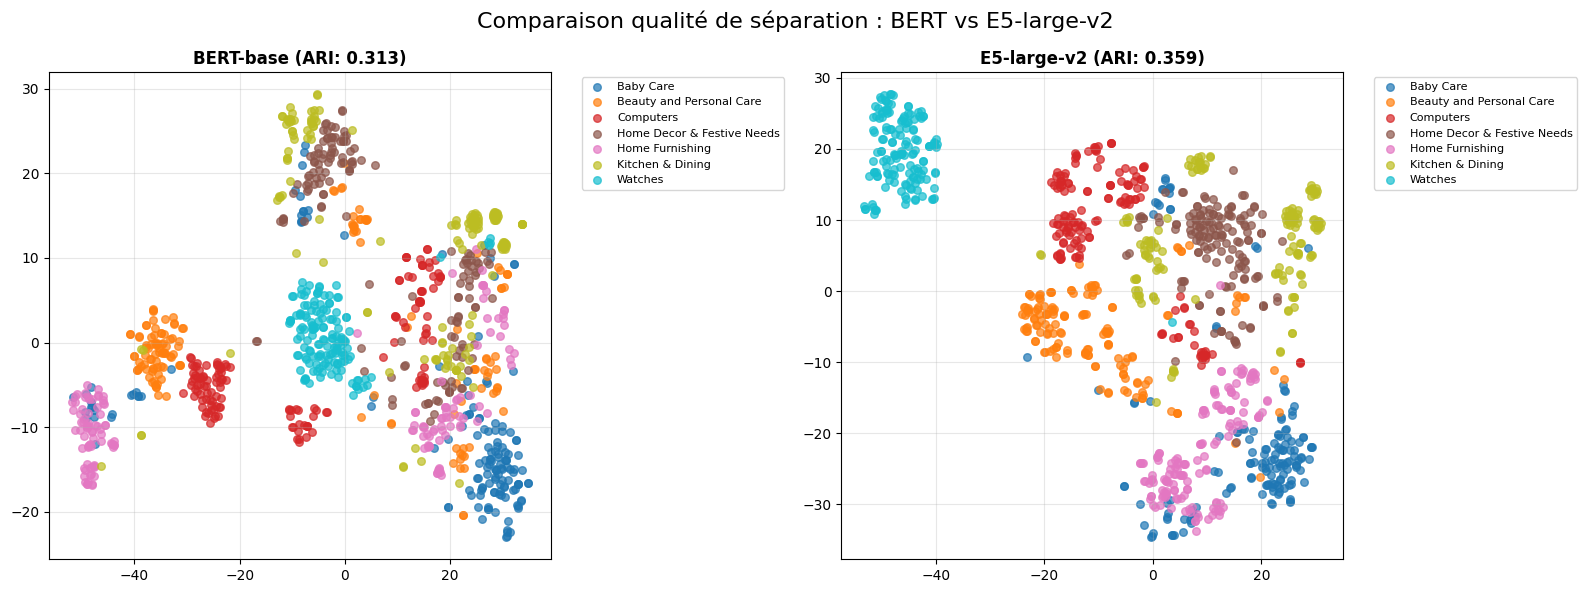

In [ ]:
# t-SNE BERT
tsne_bert = TSNE(n_components=2, perplexity=50, random_state=42, n_iter=1000)
bert_tsne_coords = tsne_bert.fit_transform(bert_embeddings)

# t-SNE E5
tsne_e5 = TSNE(n_components=2, perplexity=50, random_state=42, n_iter=1000)
e5_tsne_coords = tsne_e5.fit_transform(e5_embeddings)

# Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

categories_unique = np.unique(categories)
colors = plt.cm.tab10(np.linspace(0, 1, len(categories_unique)))

# BERT t-SNE
for i, category in enumerate(categories_unique):
    mask = np.array(categories) == category
    axes[0].scatter(bert_tsne_coords[mask, 0], bert_tsne_coords[mask, 1],
                   c=[colors[i]], label=category, alpha=0.7, s=30)

axes[0].set_title(f'BERT-base (ARI: {ari_bert:.3f})', fontweight='bold')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(True, alpha=0.3)

# E5 t-SNE
for i, category in enumerate(categories_unique):
    mask = np.array(categories_e5) == category
    axes[1].scatter(e5_tsne_coords[mask, 0], e5_tsne_coords[mask, 1],
                   c=[colors[i]], label=category, alpha=0.7, s=30)

axes[1].set_title(f'E5-large-v2 (ARI: {ari_e5:.3f})', fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Comparaison qualité de séparation : BERT vs E5-large-v2', fontsize=16)
plt.tight_layout()
plt.show()

La visualisation t-SNE suggère une légère amélioration de la séparation avec E5-large-v2, cohérente avec l'amélioration ARI de +14.7%.

# Matrices de confusion

Visualisation comparative des matrices de confusion pour révéler les patterns
d'erreur spécifiques à chaque modèle. Cette analyse  identifie les
catégories problématiques et les confusions récurrentes, permettant de comprendre où E5-large-v2 améliore concrètement la discrimination par rapport à BERT.

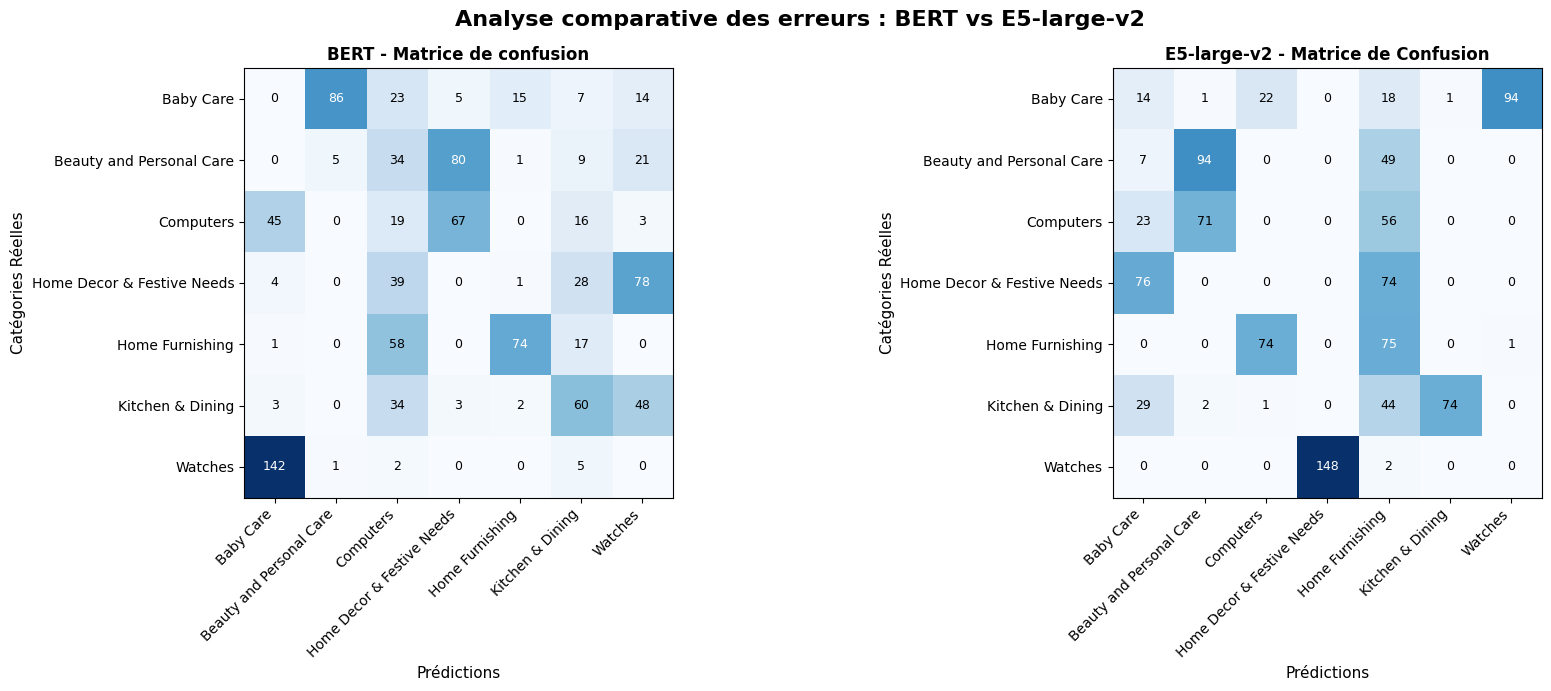

In [ ]:
# Matrices de confusion côte à côte
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

categories_unique = label_encoder.classes_

# Matrice BERT
im1 = axes[0].imshow(cm_bert, interpolation='nearest', cmap=plt.cm.Blues)
axes[0].set_title(f'BERT - Matrice de confusion',
                 fontweight='bold', fontsize=12)

# Labels et valeurs BERT
tick_marks = np.arange(len(categories_unique))
axes[0].set_xticks(tick_marks)
axes[0].set_yticks(tick_marks)
axes[0].set_xticklabels(categories_unique, rotation=45, ha='right', fontsize=10)
axes[0].set_yticklabels(categories_unique, fontsize=10)

thresh_bert = cm_bert.max() / 2.
for i in range(cm_bert.shape[0]):
   for j in range(cm_bert.shape[1]):
       axes[0].text(j, i, format(cm_bert[i, j], 'd'),
                   ha="center", va="center", fontsize=9,
                   color="white" if cm_bert[i, j] > thresh_bert else "black")

axes[0].set_ylabel('Catégories Réelles', fontsize=11)
axes[0].set_xlabel('Prédictions', fontsize=11)

# Matrice E5
im2 = axes[1].imshow(cm_e5, interpolation='nearest', cmap=plt.cm.Blues)
axes[1].set_title(f'E5-large-v2 - Matrice de Confusion',
                 fontweight='bold', fontsize=12)

# Labels et valeurs E5
axes[1].set_xticks(tick_marks)
axes[1].set_yticks(tick_marks)
axes[1].set_xticklabels(categories_unique, rotation=45, ha='right', fontsize=10)
axes[1].set_yticklabels(categories_unique, fontsize=10)

thresh_e5 = cm_e5.max() / 2.
for i in range(cm_e5.shape[0]):
   for j in range(cm_e5.shape[1]):
       axes[1].text(j, i, format(cm_e5[i, j], 'd'),
                   ha="center", va="center", fontsize=9,
                   color="white" if cm_e5[i, j] > thresh_e5 else "black")

axes[1].set_ylabel('Catégories Réelles', fontsize=11)
axes[1].set_xlabel('Prédictions', fontsize=11)

plt.suptitle('Analyse comparative des erreurs : BERT vs E5-large-v2', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

E5 vs BERT
*   Baby Care: +14 classifications correctes
*   Beauty and Personal Care: +89 classifications correctes
*   Computers: -19 classifications correctes
*   Home Furnishing: +1 classifications correctes
*   Kitchen & Dining: +14 classifications correctes

Principales confusions BERT:
*   Watches -> Baby Care: 142 erreurs
*   Baby Care -> Beauty and Personal Care: 86 erreurs
*   Beauty and Personal Care -> Home Decor & Festive Needs: 80 erreurs

Principales confusions E5:
*   Watches -> Home Decor & Festive Needs: 148 erreurs
*   Baby Care -> Watches: 94 erreurs
*   Home Decor & Festive Needs -> Baby Care: 76 erreurs

# Importance globale et locale (Shap)

Cette section implémente l'analyse de feature importance globale et locale
requise par le template de note méthodologique. L'objectif est de comprendre
quelles dimensions des embeddings E5-large-v2 (1024D) contribuent le plus
à la discrimination entre catégories de produits e-commerce.

Méthodologie:
- Random Forest comme modèle proxy pour l'interprétabilité des embeddings
- SHAP (SHapley Additive exPlanations) pour quantifier l'importance des features
- Analyse à deux niveaux : globale (patterns généraux) et locale (prédictions individuelles)

Contraintes techniques:
- Subset de 100 échantillons pour performance sur CPU (SHAP très coûteux)
- Échantillonnage stratifié pour maintenir représentativité des catégories

Modèle entraîné - Accuracy: 0.9048


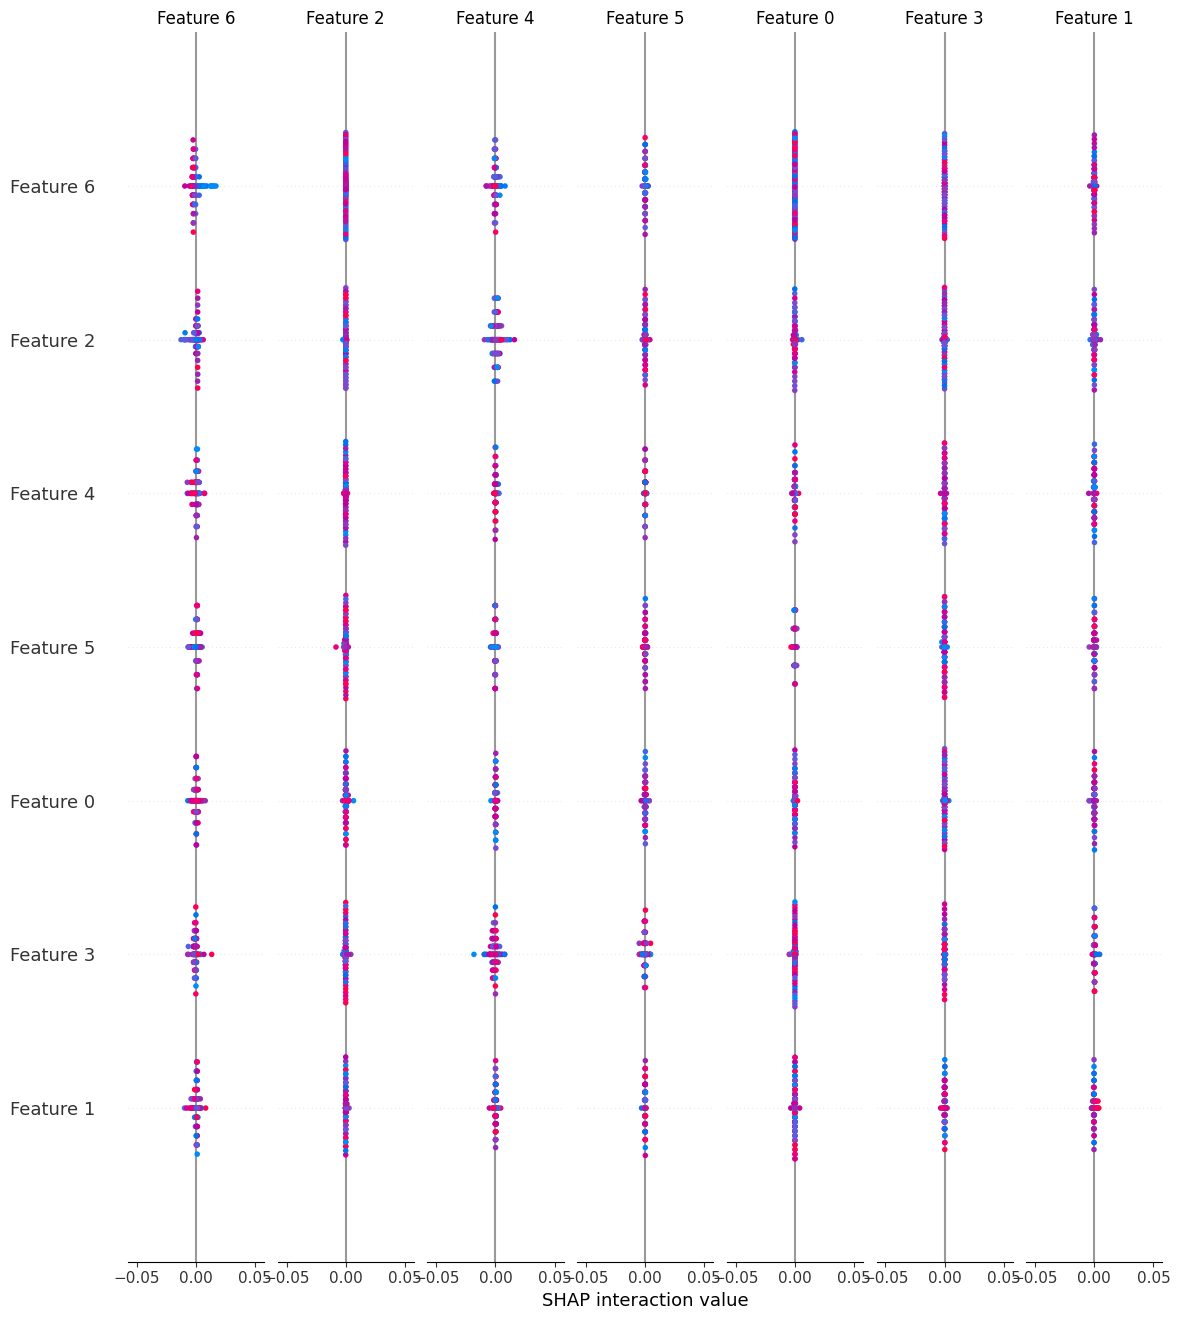

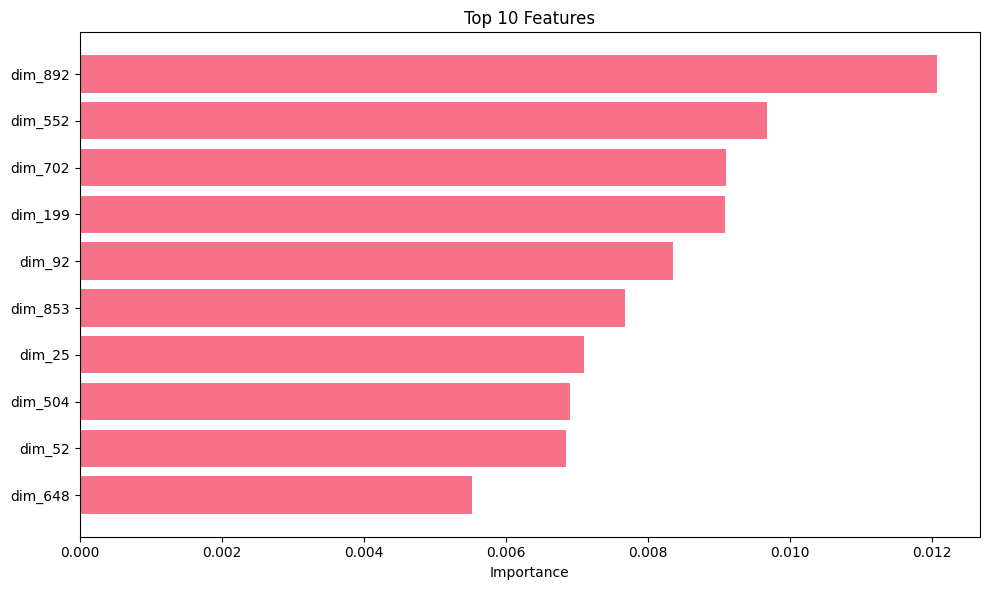

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import shap

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(
    e5_embeddings, categories, test_size=0.2, random_state=42, stratify=categories
)

# Encodage des classes
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Modèle
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train_encoded)
print(f"Modèle entraîné - Accuracy: {rf.score(X_test, y_test_encoded):.4f}")

# SHAP : Calcul des valeurs
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test[:100])  # Pour performance

# SHAP global : summary plot (classe 0 et éventuellement classe 1)
if isinstance(shap_values, list):  # multi-classes
    for i, class_shap in enumerate(shap_values[:2]):  # max 2 classes pour simplifier
        shap.summary_plot(class_shap, X_test[:100], max_display=15, show=False)
        plt.title(f"Classe: {label_encoder.classes_[i]}")
        plt.tight_layout()
        plt.show()
else:  # binaire
    shap.summary_plot(shap_values, X_test[:100], max_display=15)

# RandomForest Feature Importance
importances = rf.feature_importances_
top_rf_idx = np.argsort(importances)[-10:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_rf_idx)), importances[top_rf_idx])
plt.yticks(range(len(top_rf_idx)), [f"dim_{i}" for i in top_rf_idx])
plt.xlabel("Importance")
plt.title("Top 10 Features")
plt.tight_layout()
plt.show()

Ce graphique montre l'importance globale des dimensions d'embeddings E5-large-v2 dans la classification des produits e-commerce.

Les points représentent des valeurs SHAP pour chaque dimension d'embedding, et chaque colonne représente une classe de produit. Les points rouges indiquent les valeurs élevées de la dimension, tandis que les points bleus montrent les valeurs faibles.

Les dimensions comme Feature 6, Feature 2, et Feature 4 ont une forte influence sur les prédictions, car les points sont bien dispersés sur l'axe horizonta: elles contribuent fortement à discriminer les catégories de produits.

Les points proches de 0 sur l'axe horizontal signifient que la dimension n'a pas beaucoup d'influence sur la classification pour certaines instances.

Chaque colonne (classe de produit) présente une signature spécifique: E5-large-v2 capture les nuances sémantiques entre les catégories e-commerce.



Le graphique Top 10 Features Random Forest montre que les dimensions dim_892, dim_552, et dim_702 sont les plus discriminantes selon Random Forest, E5-large-v2 concentre l'information sur un nombre restreint de dimensions pour une classification des produits.

Échantillon 0: Baby Care → Baby Care


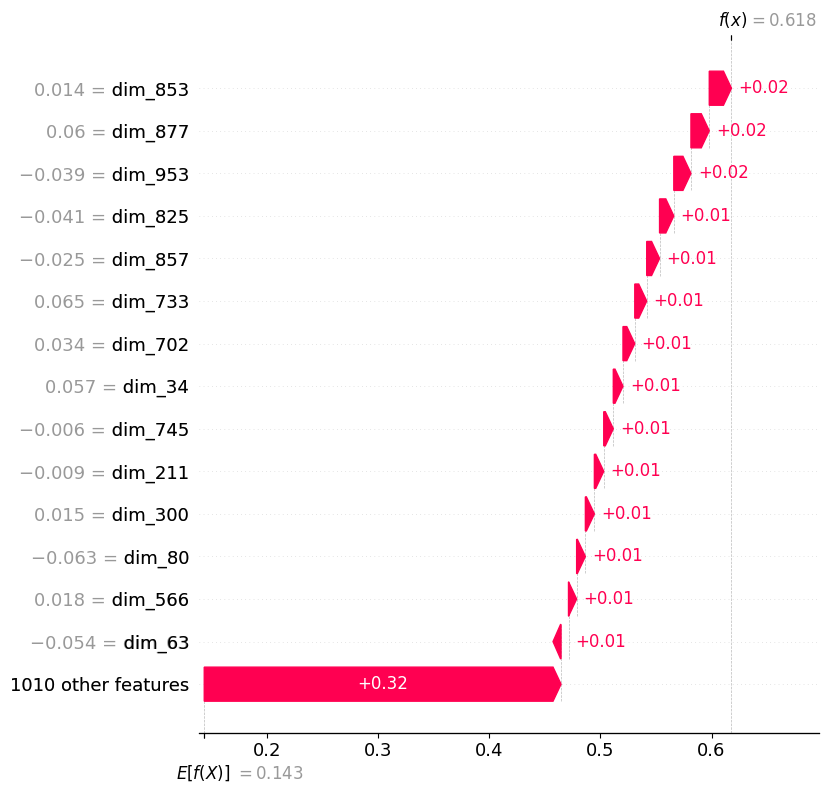

In [ ]:
# Analyser un échantillon
sample_idx = 0
pred_class = rf.predict(X_test[sample_idx:sample_idx+1])[0]
pred_class_name = label_encoder.classes_[pred_class]
true_class_name = y_test[sample_idx]

print(f"Échantillon {sample_idx}: {true_class_name} → {pred_class_name}")

# Extraire les valeurs SHAP pour la classe prédite
sample_shap_values = shap_values[sample_idx][:, pred_class]
sample_features = X_test[sample_idx]
base_value = explainer.expected_value[pred_class]

# Créer et afficher le waterfall
explanation = shap.Explanation(
    values=sample_shap_values,
    base_values=base_value,
    data=sample_features,
    feature_names=[f"dim_{i}" for i in range(len(sample_features))]
)

shap.waterfall_plot(explanation, max_display=15)

Ce graphique montre comment les dimensions d'embedding E5-large-v2 contribuent individuellement à la prédiction "Baby Care" pour un échantillon spécifique.

Le graphique part de la valeur de base du modèle (E[f(X)] = 0.143) et montre comment chaque dimension modifie cette prédiction pour arriver au score final f(x) = 0.618.


Les dimensions dim_853 (+0.02), dim_877 (+0.02), et dim_733 (+0.01) renforcent la prédiction vers "Baby Care".
Les dimensions dim_220 (-0.01), dim_80 (-0.01), et dim_825 (-0.01) diminuent légèrement la probabilité de classification en "Baby Care".
 Les "1010 other features" (+0.33) représentent l'effet combiné de toutes les autres dimensions, montrant que E5-large-v2 utilise l'ensemble de ses 1024 dimensions pour cette classification.